In [67]:
#!pip install tslearn
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_circles
from sklearn.metrics.pairwise import pairwise_kernels

from tslearn.clustering import KernelKMeans

import random
import matplotlib.pyplot as plt

In [68]:
seed = 42
n_samples = 10

X, y = make_circles(n_samples=n_samples, factor=0.2, noise=0.05, random_state=seed)

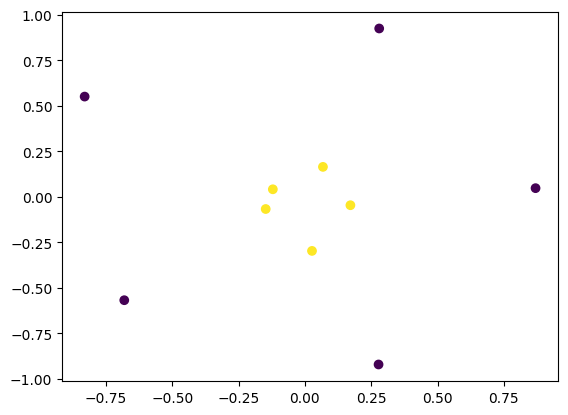

In [69]:
plt.scatter(X[:, 0], X[:, 1], c=y)

C:\Users\APDHP-DM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


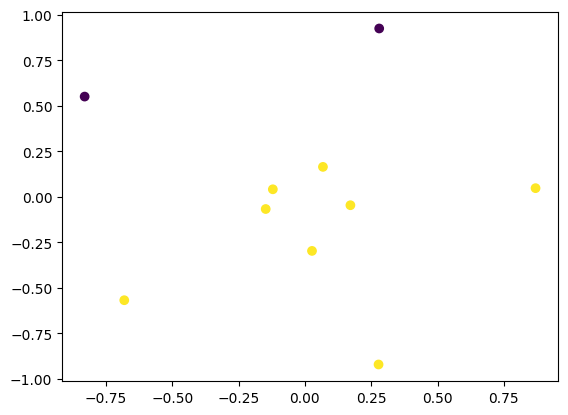

In [70]:
kmeans = KMeans(n_clusters=2).fit(X)
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)

C:\Users\APDHP-DM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 10 1-dimensional timeseries
  warnings.warn(


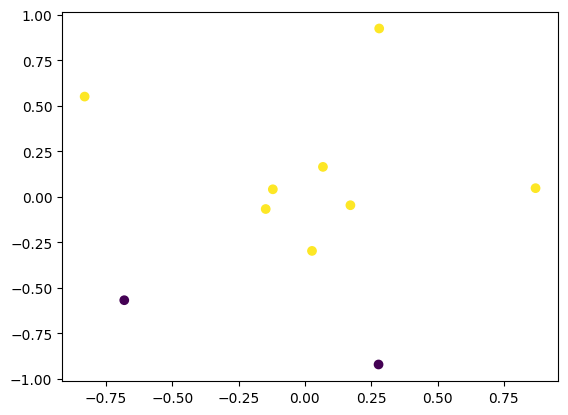

In [71]:
kernel = 'rbf'
kernel = pairwise_kernels(X, X, metric='rbf', gamma=5)
# Should find a way to init the fucking centers!
kernel_kmeans = KernelKMeans(n_clusters=2, n_init=1, kernel='precomputed').fit(kernel)
plt.scatter(X[:, 0], X[:, 1], c=kernel_kmeans.labels_)
plt.show()

### We want a function that given the kernel and number of clusters to return me the initial partition using the kernel k-means++ algorithm

In [113]:
def calculate_kernel_distances_between_points(center_index, X, kernel_matrix, kernel_distances_between_points):
    for i in range(X.shape[0]):
        kernel_distances_between_points[center_index, i] = kernel_matrix[center_index, center_index] - 2 * kernel_matrix[center_index, i] + kernel_matrix[i, i]
    return kernel_distances_between_points

def get_initial_center_index(X):
    return random.randint(0, X.shape[0] - 1)

def select_next_center_index(centers_indices, probability_array):
    while(True):
        selected_index = np.random.choice(len(probability_array), p=probability_array)
        if(selected_index not in centers_indices):
            return selected_index

def calculate_points_probabilities_to_be_selected(kernel_distances_between_points):
    return kernel_distances_between_points / np.sum(kernel_distances_between_points)

def calculate_minimum_distances_from_centers_and_partition(centers_indices, kernel_distances_between_points):
    minimum_distances = np.zeros(kernel_distances_between_points.shape[1])
    partition = np.zeros(kernel_distances_between_points.shape[1], dtype=int)

    for i, column in enumerate(kernel_distances_between_points.T):
        nonzero_indices = np.nonzero(column)[0]
        if len(nonzero_indices) > 0:
            partition[i] = nonzero_indices[np.argmin(column[nonzero_indices])]
            minimum_distances[i] = column[partition[i]]
    
    # Make 0 the distances for centers and set their partition to their index
    minimum_distances[centers_indices] = 0
    partition[centers_indices] = centers_indices
    
    return minimum_distances, partition

def calculate_initial_partition(K, X, kernel_matrix):
    centers_indices = []
    n_samples = X.shape[0]
    kernel_distances_between_points = np.zeros((n_samples, n_samples))
    
    i = 0
    while i < K:
        if i != 0:
            centers_indices.append(select_next_center_index(centers_indices, probabilities))
        else:
            centers_indices.append(get_initial_center_index(X))
        print(f"\n {i} Center Finding Procedure")
        print(f"\n centers_indices are: {centers_indices}")
        kernel_distances_between_points = calculate_kernel_distances_between_points(centers_indices[i], X, kernel_matrix, kernel_distances_between_points)
        #print(f"\n new kernel_distances_between_points are: {kernel_distances_between_points}")
        minimum_distances, partition = calculate_minimum_distances_from_centers_and_partition(centers_indices, kernel_distances_between_points)
        print(f"\n minimum_distances are: {minimum_distances} and partition is: {partition}")
        probabilities = calculate_points_probabilities_to_be_selected(minimum_distances)
        i += 1

    return partition


In [115]:
def kernel_kmeans_pp(X, K, kernel_matrix, n_init=10):
    for i in range(n_init):
        print(f"\n Start: {i}")
        calculate_initial_partition(K, X, kernel_matrix)
        print(f"\n End: {i}")
K = 2
gaussian_kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=5)
kernel_matrix = gaussian_kernel_matrix
kernel_kmeans_pp(X, 2, kernel_matrix)


 Start: 0

 0 Center Finding Procedure

 centers_indices are: [4]

 minimum_distances are: [0.12090502 1.98192019 0.7448154  1.98516913 0.         1.95585635
 0.9888449  1.99120276 1.93492816 0.44884349] and partition is: [4 4 4 4 4 4 4 4 4 4]

 1 Center Finding Procedure

 centers_indices are: [4, 6]

 minimum_distances are: [0.12090502 1.98192019 0.68564748 1.96831789 0.         1.95585635
 0.         1.79161506 1.88670753 0.44884349] and partition is: [4 4 6 6 4 4 6 6 6 4]

 End: 0

 Start: 1

 0 Center Finding Procedure

 centers_indices are: [4]

 minimum_distances are: [0.12090502 1.98192019 0.7448154  1.98516913 0.         1.95585635
 0.9888449  1.99120276 1.93492816 0.44884349] and partition is: [4 4 4 4 4 4 4 4 4 4]

 1 Center Finding Procedure

 centers_indices are: [4, 8]

 minimum_distances are: [0.12090502 1.98192019 0.7448154  1.98516913 0.         1.95585635
 0.9888449  1.98916175 0.         0.44884349] and partition is: [4 4 4 4 4 4 4 8 8 4]

 End: 1

 Start: 2

 0 Cen